# Dam Dataset Comparison

This notebook compares the two dam datasets used in the project:
1. GRAND database (used in `3_Dams_AEI_Targeting_Ratios.ipynb`)
2. AridAfrica_Barriers (used in `1_GDW_AEI_Targeting_Ratio.ipynb`)

The goal is to understand why these datasets lead to different targeting ratio results.

## Notebook Setup

We import required libraries and utility functions for spatial data loading and analysis.

In [1]:
# Import libraries and utility functions
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path
from Code.utils.spatial_utility import load_and_reproject

# Load configuration
config = load_config()

## Load Both Dam Datasets

We load the GRAND and AridAfrica_Barriers dam datasets using the utility loader for consistent CRS and path handling.

In [2]:
# Load dam datasets using utility functions
grand_dams = load_and_reproject(config['Africa_Dam_All_shp_path'])
arid_barriers = load_and_reproject(config['AridAfrica_Barriers_shp_path'])

# Print basic information about both datasets
print(f"GRAND database dams: {len(grand_dams)}")
print(f"AridAfrica_Barriers dams: {len(arid_barriers)}")

GRAND database dams: 278
AridAfrica_Barriers dams: 2764


## Compare Dataset Schemas

We compare the columns in each dataset to understand their structure and identify common attributes.

In [3]:
# Compare columns in both datasets
print("GRAND database columns:")
print(grand_dams.columns.tolist())
print("\nAridAfrica_Barriers columns:")
print(arid_barriers.columns.tolist())

# Check for common columns
common_columns = set(grand_dams.columns).intersection(set(arid_barriers.columns))
print(f"\nCommon columns: {common_columns}")

GRAND database columns:
['Country', 'ISO', 'Sec_cntry', 'Name', 'AltDamName', 'Purpose', 'Admin_unit', 'Near_city', 'River', 'Main_basin', 'Sub_basin', 'Status', 'PVOUT', 'PotentialP', 'PV_Install', 'PV_SpaCapa', 'Dam_hgt', 'Res_capaci', 'Res_area_k', 'HPP_Instal', 'Transm_exi', 'Transm_len', 'Transm_pla', 'Proj_type', 'Lifecycle', 'Storage_ty', 'Linked_prj', 'Proj_cost', 'Proj_statu', 'Study_stat', 'YEAR', 'Yr_recents', 'Comission_', 'Ann_firm_g', 'Ann_tot_ge', 'Prox_irrig', 'Size_irrig', 'Owner', 'Autom_EMS_', 'PrivateOwn', 'Feed_in_ta', 'Feed_in__1', 'Guaranteed', 'Competitiv', 'Winning_bi', 'OtherFisca', 'Prioritize', 'Priority_d', 'Compensati', 'Compensa_1', 'Gov_guaran', 'Regulatory', 'Download', 'Longitude', 'Latitude', 'Lat__hydro', 'Long__hydr', 'Database', 'Notes', 'geometry']

AridAfrica_Barriers columns:
['USE_OTHR', 'DOR_PC', 'DATA_INFO', 'HYLAK_ID', 'LAKE_CTRL', 'COUNTRY', 'REM_YEAR', 'POWER_MW', 'SUB_BASIN', 'DIS_AVG_LS', 'TIMELINE', 'YEAR_DAM', 'LAT_DAM', 'INSTREAM', 'A

## Compare Spatial Distribution

We visualize the spatial distribution of dams from both datasets on a single map for direct comparison.

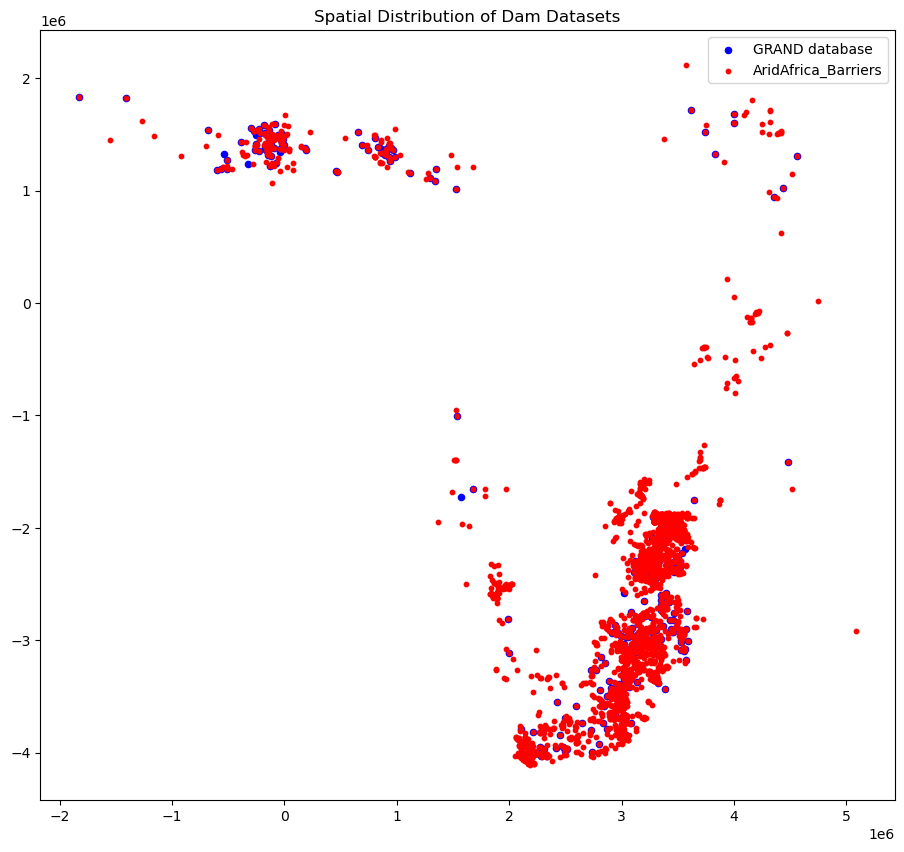

In [4]:
# Ensure both datasets are in the same CRS (should already be handled by loader, but double-check)
grand_dams = grand_dams.to_crs("EPSG:3857")
arid_barriers = arid_barriers.to_crs("EPSG:3857")

# Plot both datasets on the same map
fig, ax = plt.subplots(figsize=(12, 10))
grand_dams.plot(ax=ax, color='blue', markersize=20, label='GRAND database')
arid_barriers.plot(ax=ax, color='red', markersize=10, label='AridAfrica_Barriers')
ax.set_title('Spatial Distribution of Dam Datasets')
ax.legend()
plt.show()

## Compare Dam Attributes

We compare dam attributes, such as height, to see if attribute distributions differ between datasets.

In [5]:
# Compare dam height statistics if available
if 'DAM_HGT_M' in grand_dams.columns and 'DAM_HGT_M' in arid_barriers.columns:
    print("Dam height statistics:")
    print("GRAND database:")
    print(grand_dams['DAM_HGT_M'].describe())
    print("\nAridAfrica_Barriers:")
    print(arid_barriers['DAM_HGT_M'].describe())
    
    # Plot height distributions
    fig, ax = plt.subplots(figsize=(10, 6))
    grand_dams['DAM_HGT_M'].hist(ax=ax, alpha=0.5, bins=20, label='GRAND database')
    arid_barriers['DAM_HGT_M'].hist(ax=ax, alpha=0.5, bins=20, label='AridAfrica_Barriers')
    ax.set_title('Dam Height Distribution')
    ax.set_xlabel('Height (m)')
    ax.set_ylabel('Count')
    ax.legend()
    plt.show()

## Compare Country Distribution

We compare the number of dams per country in each dataset.

In [6]:
# Compare country distribution in both datasets
if 'ISO' in grand_dams.columns and 'ISO' in arid_barriers.columns:
    grand_countries = grand_dams['ISO'].value_counts()
    arid_countries = arid_barriers['ISO'].value_counts()
    
    # Create a DataFrame to compare
    country_comparison = pd.DataFrame({
        'GRAND': grand_countries,
        'AridAfrica': arid_countries
    }).fillna(0)
    
    print(country_comparison)
    
    # Plot comparison
    country_comparison.plot(kind='bar', figsize=(12, 8))
    plt.title('Dam Count by Country')
    plt.ylabel('Number of Dams')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Analyze Targeting Ratio Differences

We load CPIS and AEI data, then compare the distance from CPIS points to the nearest dam in each dataset using a utility function for distance calculation.

In [7]:
# Load CPIS and AEI data using utility.resolve_path for consistent path handling
cpis = gpd.read_file(resolve_path(config['SSA_Combined_CPIS_All_shp_path'])).to_crs("EPSG:3857")
aei = gpd.read_file(resolve_path(config['AEI_2015_All_shp_path'])).to_crs("EPSG:3857")

print(f"CPIS count: {len(cpis)}")
print(f"AEI count: {len(aei)}")

CPIS count: 29493
AEI count: 16920


### Calculate and Compare Distances

We use a utility function to calculate the distance from each CPIS point to the nearest dam in each dataset, then compare the distributions.

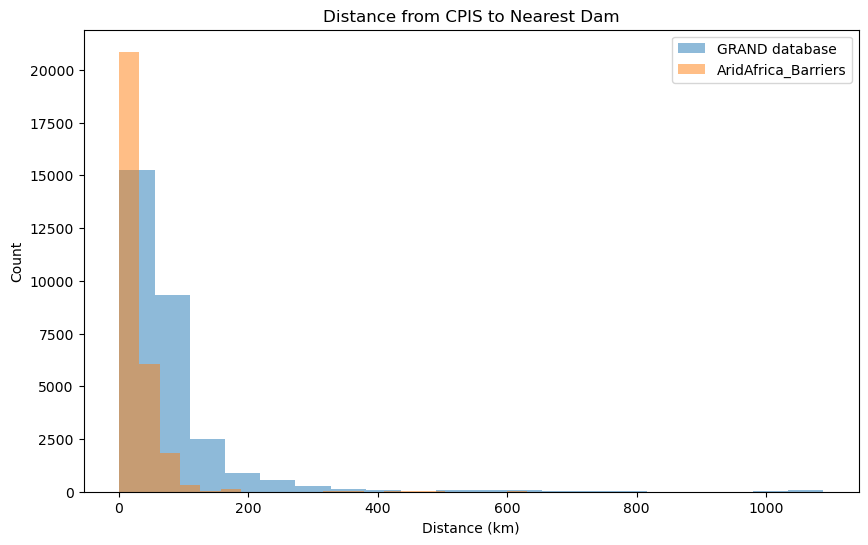

Distance statistics (km):
GRAND database:
count    29493.000000
mean        78.914414
std        101.816311
min          0.928122
25%         32.015641
50%         53.373581
75%         84.222098
max       1088.855557
dtype: float64

AridAfrica_Barriers:
count    29493.000000
mean        29.005927
std         46.097947
min          0.033577
25%          8.712357
50%         18.710486
75%         35.457822
max        630.657871
dtype: float64


In [8]:
from scipy.spatial import cKDTree

def calculate_distances(src_gdf, target_gdf):
    """Calculate distances from source points to nearest target points."""
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return np.array([])  # Return empty array if no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Calculate distances using both dam datasets
cpis_to_grand_distances = calculate_distances(cpis, grand_dams)
cpis_to_arid_distances = calculate_distances(cpis, arid_barriers)

# Compare distance distributions
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(cpis_to_grand_distances/1000, bins=20, alpha=0.5, label='GRAND database')
ax.hist(cpis_to_arid_distances/1000, bins=20, alpha=0.5, label='AridAfrica_Barriers')
ax.set_title('Distance from CPIS to Nearest Dam')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Count')
ax.legend()
plt.show()

# Print basic statistics
print("Distance statistics (km):")
print("GRAND database:")
print(pd.Series(cpis_to_grand_distances/1000).describe())
print("\nAridAfrica_Barriers:")
print(pd.Series(cpis_to_arid_distances/1000).describe())